# Statistical Feature Detector Evaluation

## Empirical Analysis of Mahalanobis Distance-Based Anomaly Detection for MCP Security

---

### Abstract

This notebook presents a comprehensive evaluation of the Statistical Feature Detector, a component of the MCP Security Gateway ensemble that employs rich feature extraction and Mahalanobis distance for binary anomaly detection. The detector extracts multiple statistical features from request payloads and classifies them based on their distance to learned class distributions.

### Detector Characteristics

| Property | Value |
|----------|-------|
| **Type** | Statistical Anomaly Detection |
| **Method** | Mahalanobis Distance |
| **Features** | 10 statistical features |
| **Training** | Per-tool class statistics |
| **Inference** | Feature extraction + distance computation |

### Feature Set

1. **Length**: Total character count
2. **Entropy**: Shannon entropy (randomness indicator)
3. **Special Character Ratio**: Non-alphanumeric characters
4. **Digit Ratio**: Numeric characters
5. **Suspicious Pattern Density**: Attack pattern frequency
6. **Alphabetic Ratio**: Letter concentration
7. **Uppercase Ratio**: Capitalization patterns
8. **Whitespace Ratio**: Space distribution
9. **Max Token Length**: Longest continuous token
10. **URL Pattern Count**: URL/path pattern density

---

## 1. Environment Configuration

In [1]:
import os
import sys
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from typing import Dict, List, Tuple, Any, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configure project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.insert(0, PROJECT_ROOT)

# Import detector
from mcp_bridge.src.core.detectors.statistical import StatisticalFeatureDetector
from mcp_bridge.src.core.detectors.base import SecurityClass

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Statistical Detector Evaluation")
print(f"="*60)
print(f"Project Root: {PROJECT_ROOT}")

Statistical Detector Evaluation
Project Root: w:\__Projects__\MCP-Security-Gateway


## 2. Visualization Configuration

In [2]:
# Color palette
COLORS = {
    'primary': '#56B4E9',      # Sky Blue - Statistical detector
    'benign': '#009E73',       # Green - Safe
    'attack': '#D55E00',       # Vermillion - Threat
    'neutral': '#7F7F7F',      # Gray
    'highlight': '#F0E442',    # Yellow
    'secondary': '#0072B2',    # Blue
}

FEATURE_COLORS = plt.cm.Set3(np.linspace(0, 1, 10))

# Publication-quality matplotlib configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Output directories
FIGURES_DIR = os.path.join(PROJECT_ROOT, 'research', 'figures', 'statistical')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'research', 'evaluation_results')
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Figures: {FIGURES_DIR}")
print(f"Results: {RESULTS_DIR}")

Figures: w:\__Projects__\MCP-Security-Gateway\research\figures\statistical
Results: w:\__Projects__\MCP-Security-Gateway\research\evaluation_results


## 3. Data Loading and Model Initialization

In [3]:
# Load datasets
TRAIN_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "training_dataset.json")
TEST_DATA_PATH = os.path.join(PROJECT_ROOT, "research", "data", "test_dataset.json")
MODELS_DIR = os.path.join(PROJECT_ROOT, "research", "trained_models")
STATISTICAL_MODEL_PATH = os.path.join(MODELS_DIR, "statistical_model.pt")

def load_dataset(path: str) -> Dict:
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    data.pop('_metadata', None)
    return data

def flatten_samples(dataset: Dict) -> List[Dict]:
    samples = []
    for tool_name, tool_data in dataset.items():
        for category in ['benign', 'attack']:
            for payload in tool_data.get(category, []):
                if isinstance(payload, dict):
                    payload_str = json.dumps(payload)
                else:
                    payload_str = str(payload)
                samples.append({
                    'tool_name': tool_name,
                    'payload': payload_str,
                    'label': category
                })
    return samples

train_dataset = load_dataset(TRAIN_DATA_PATH)
test_dataset = load_dataset(TEST_DATA_PATH)

train_samples = flatten_samples(train_dataset)
test_samples = flatten_samples(test_dataset)

print(f"Training samples: {len(train_samples)}")
print(f"Test samples: {len(test_samples)}")

Training samples: 3088
Test samples: 304


In [4]:
# Initialize and load statistical detector
stat_detector = StatisticalFeatureDetector(sigma=3.0)

if os.path.exists(STATISTICAL_MODEL_PATH):
    state = torch.load(STATISTICAL_MODEL_PATH, map_location='cpu', weights_only=False)
    stat_detector.load_state(state)
    print(f"Statistical model loaded from: {STATISTICAL_MODEL_PATH}")
    print(f"  Tools trained: {len(stat_detector.class_stats)}")
    print(f"  Features: {stat_detector.features}")
else:
    print("Pre-trained model not found. Training from scratch...")
    for tool_name, tool_data in train_dataset.items():
        benign = tool_data.get('benign', [])
        attack = tool_data.get('attack', [])
        stat_detector.fit(tool_name, benign, attack)
    print(f"Training complete: {len(stat_detector.class_stats)} tools")

Statistical model loaded from: w:\__Projects__\MCP-Security-Gateway\research\trained_models\statistical_model.pt
  Tools trained: 32
  Features: ['log_length', 'entropy', 'special_ratio', 'digit_ratio', 'suspicious_density', 'alpha_ratio', 'upper_ratio', 'whitespace_ratio', 'max_token_ratio', 'url_pattern_density']


## 4. Feature Analysis

### 4.1 Feature Extraction

In [5]:
# Extract features for all test samples
FEATURE_NAMES = [
    'Length', 'Entropy', 'Special Ratio', 'Digit Ratio',
    'Suspicious Density', 'Alpha Ratio', 'Upper Ratio',
    'Whitespace Ratio', 'Max Token Len', 'URL Pattern Count'
]

def extract_all_features(samples: List[Dict]) -> pd.DataFrame:
    """Extract statistical features for all samples."""
    data = []
    for sample in samples:
        features = stat_detector._extract_features(sample['payload'])
        data.append({
            'tool_name': sample['tool_name'],
            'label': sample['label'],
            **{FEATURE_NAMES[i]: features[i] for i in range(len(features))}
        })
    return pd.DataFrame(data)

features_df = extract_all_features(test_samples)
print(f"Extracted features for {len(features_df)} samples")
print(f"\nFeature statistics:")
print(features_df[FEATURE_NAMES].describe().round(3))

Extracted features for 304 samples

Feature statistics:
        Length  Entropy  Special Ratio  Digit Ratio  Suspicious Density  \
count  304.000  304.000        304.000      304.000             304.000   
mean     4.212    4.426          0.325        0.034               0.005   
std      0.265    0.327          0.092        0.033               0.014   
min      3.332    3.696          0.060        0.000               0.000   
25%      4.056    4.220          0.295        0.000               0.000   
50%      4.220    4.388          0.328        0.028               0.000   
75%      4.357    4.538          0.377        0.054               0.000   
max      5.257    5.576          0.659        0.164               0.119   

       Alpha Ratio  Upper Ratio  Whitespace Ratio  Max Token Len  \
count      304.000      304.000           304.000        304.000   
mean         0.567        0.090             0.074          0.155   
std          0.101        0.138             0.044          0.106

### 4.2 Feature Distribution by Class

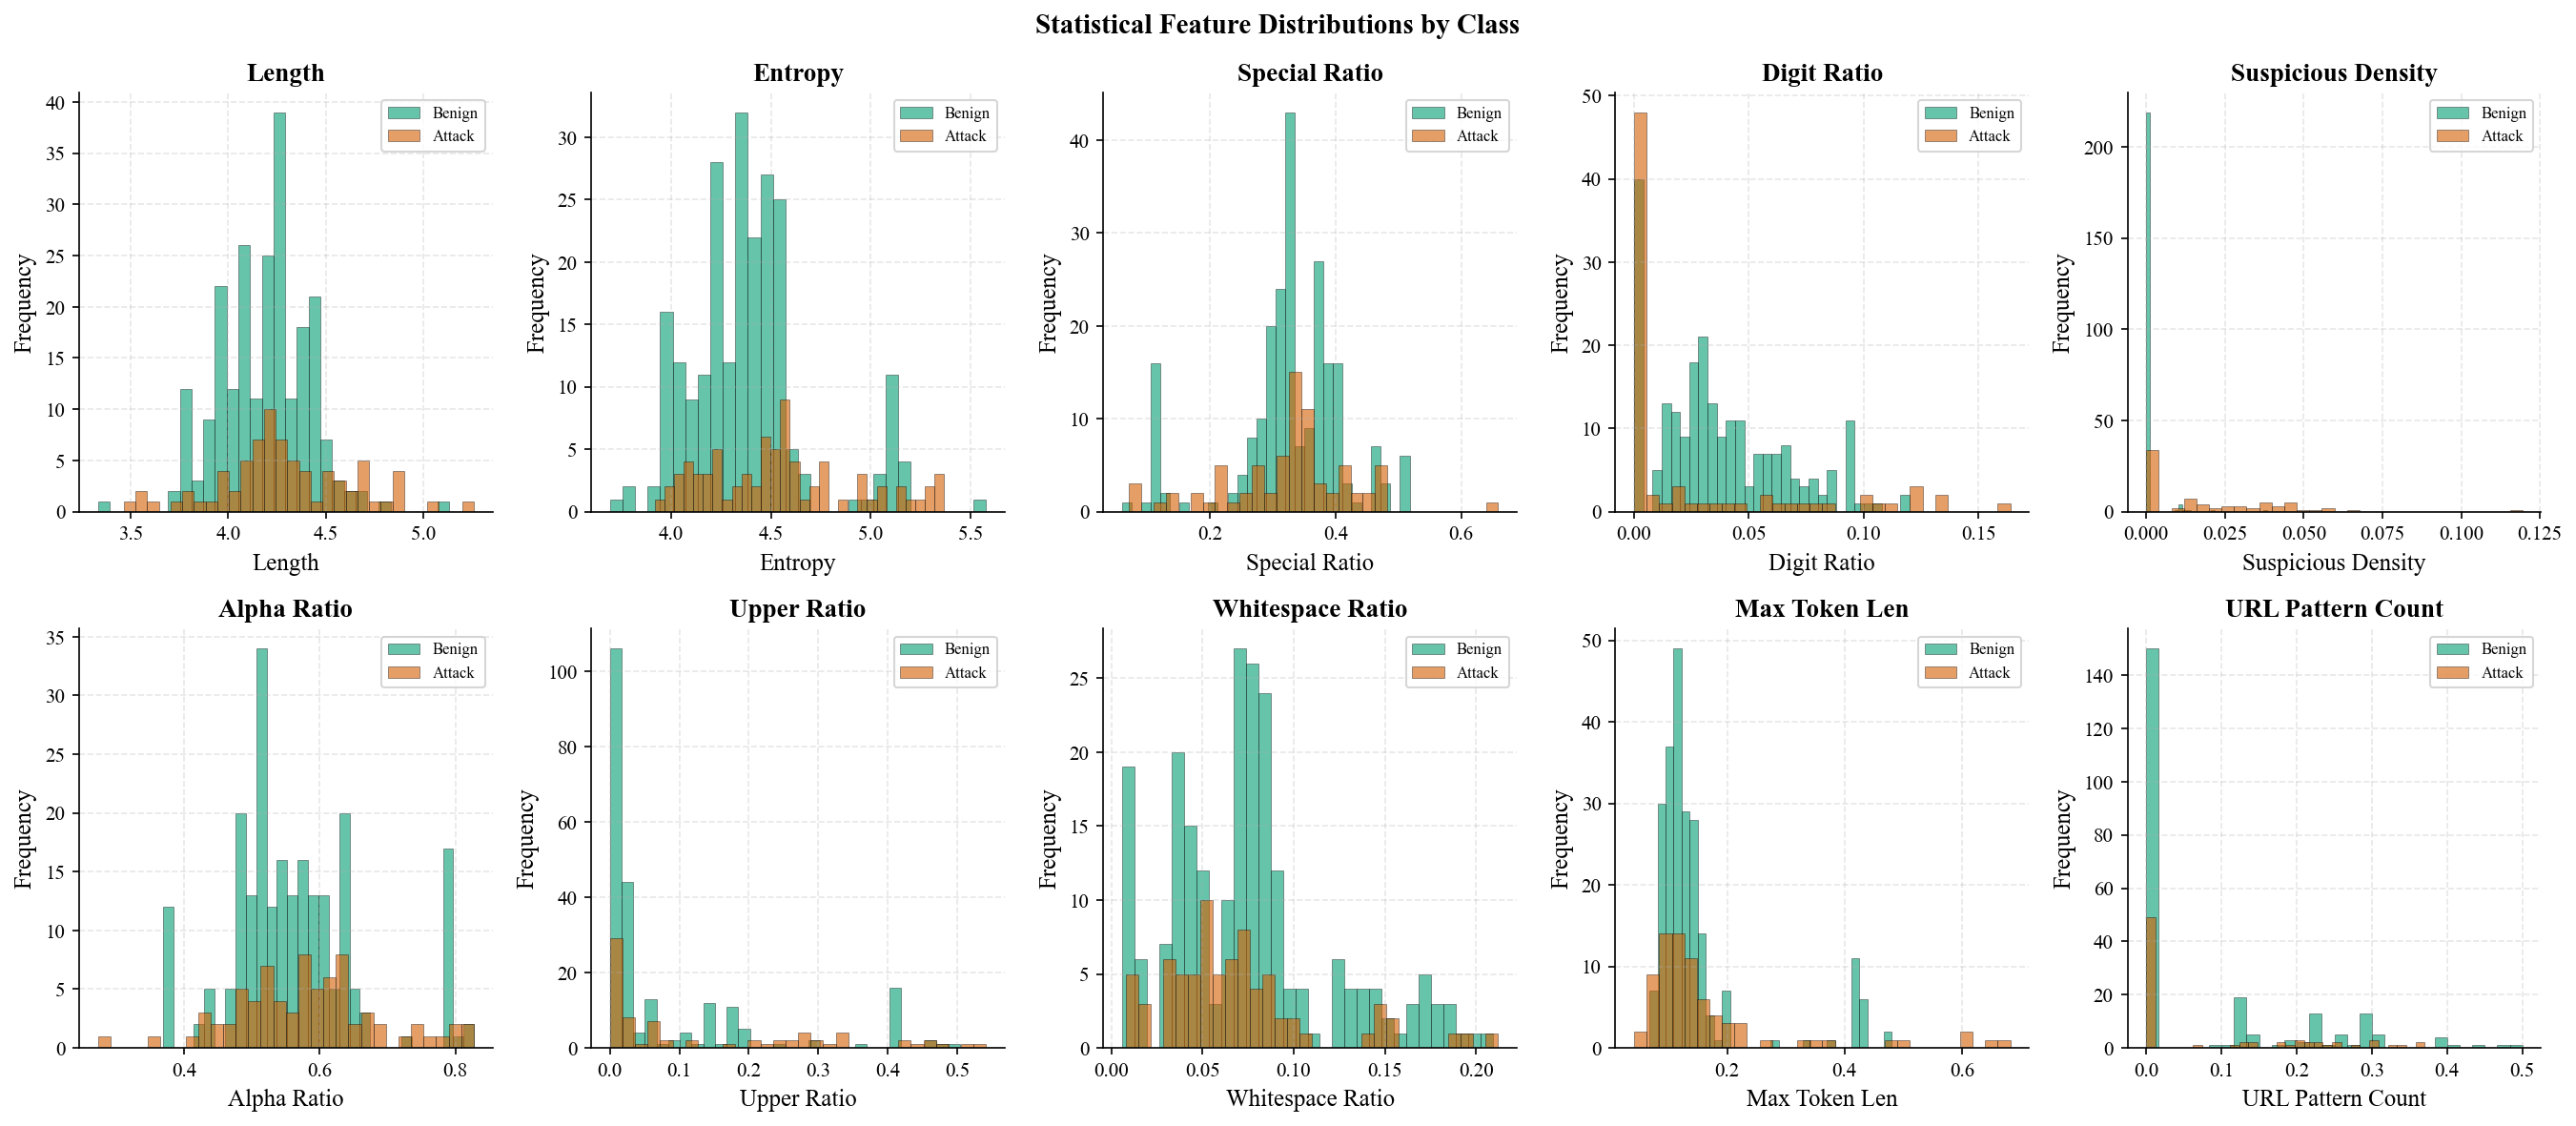

In [6]:
# Feature distributions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, feature in enumerate(FEATURE_NAMES):
    ax = axes[idx]
    
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = features_df[features_df['label'] == label][feature]
        ax.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
               color=color, edgecolor='black', linewidth=0.3)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(feature)
    ax.legend(fontsize=8)

plt.suptitle('Statistical Feature Distributions by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_distributions.png'), dpi=600)
plt.show()

### 4.3 Feature Correlation Analysis

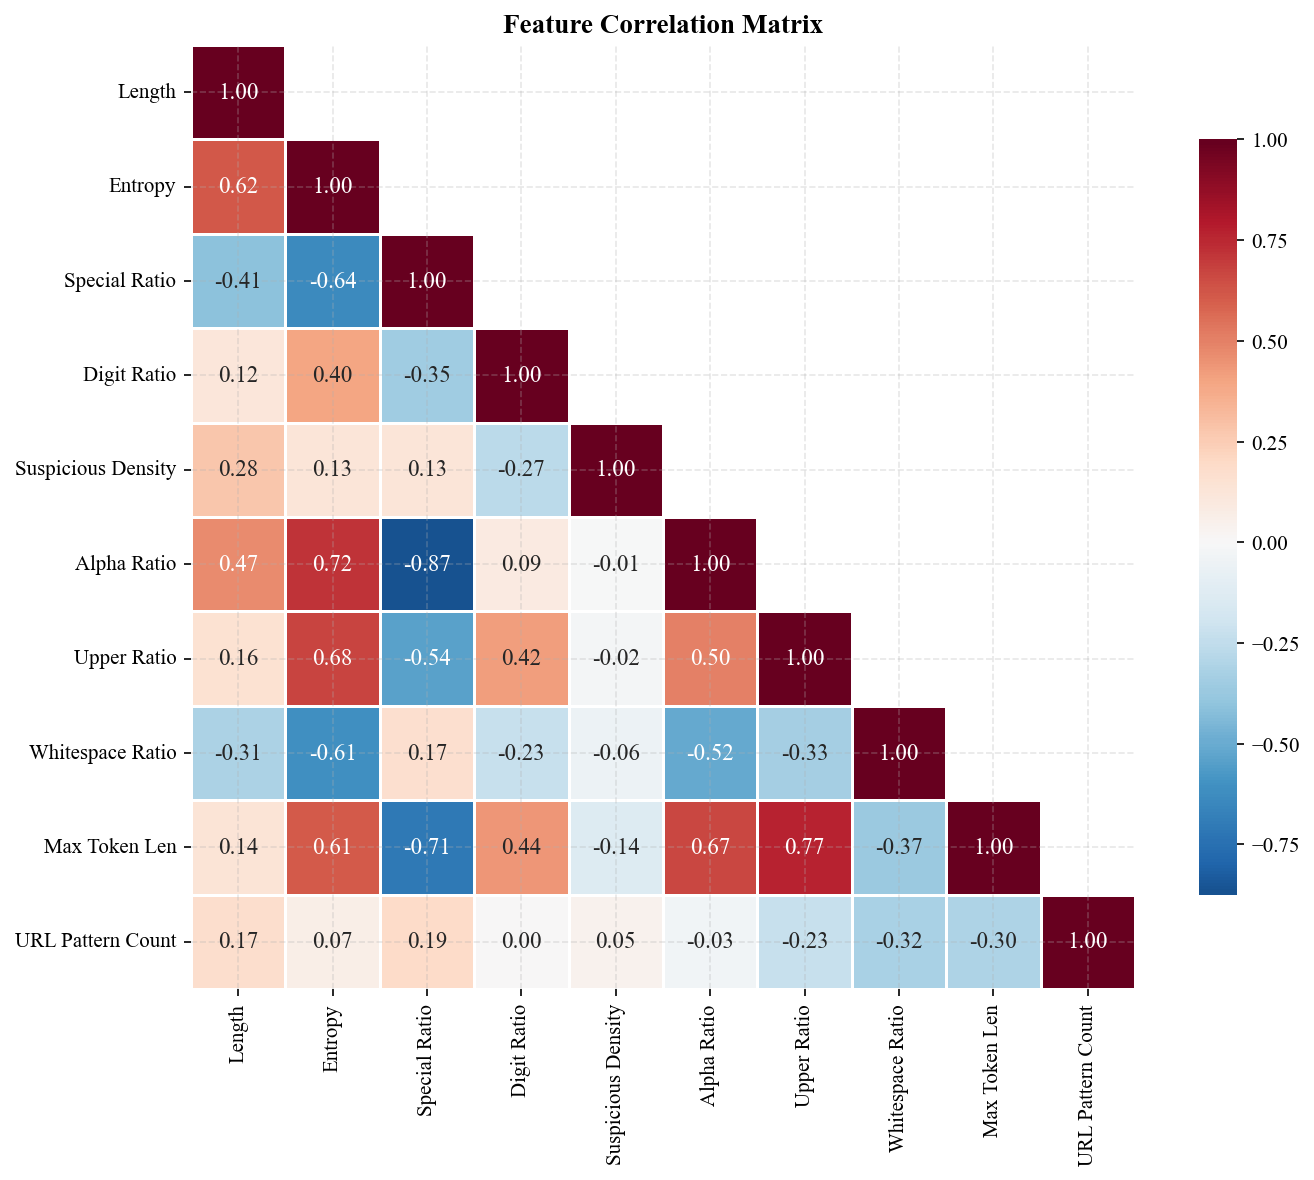

In [7]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = features_df[FEATURE_NAMES].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8},
            linewidths=0.5)

ax.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_correlation.png'), dpi=600)
plt.show()

### 4.4 Feature Importance (Class Separation)

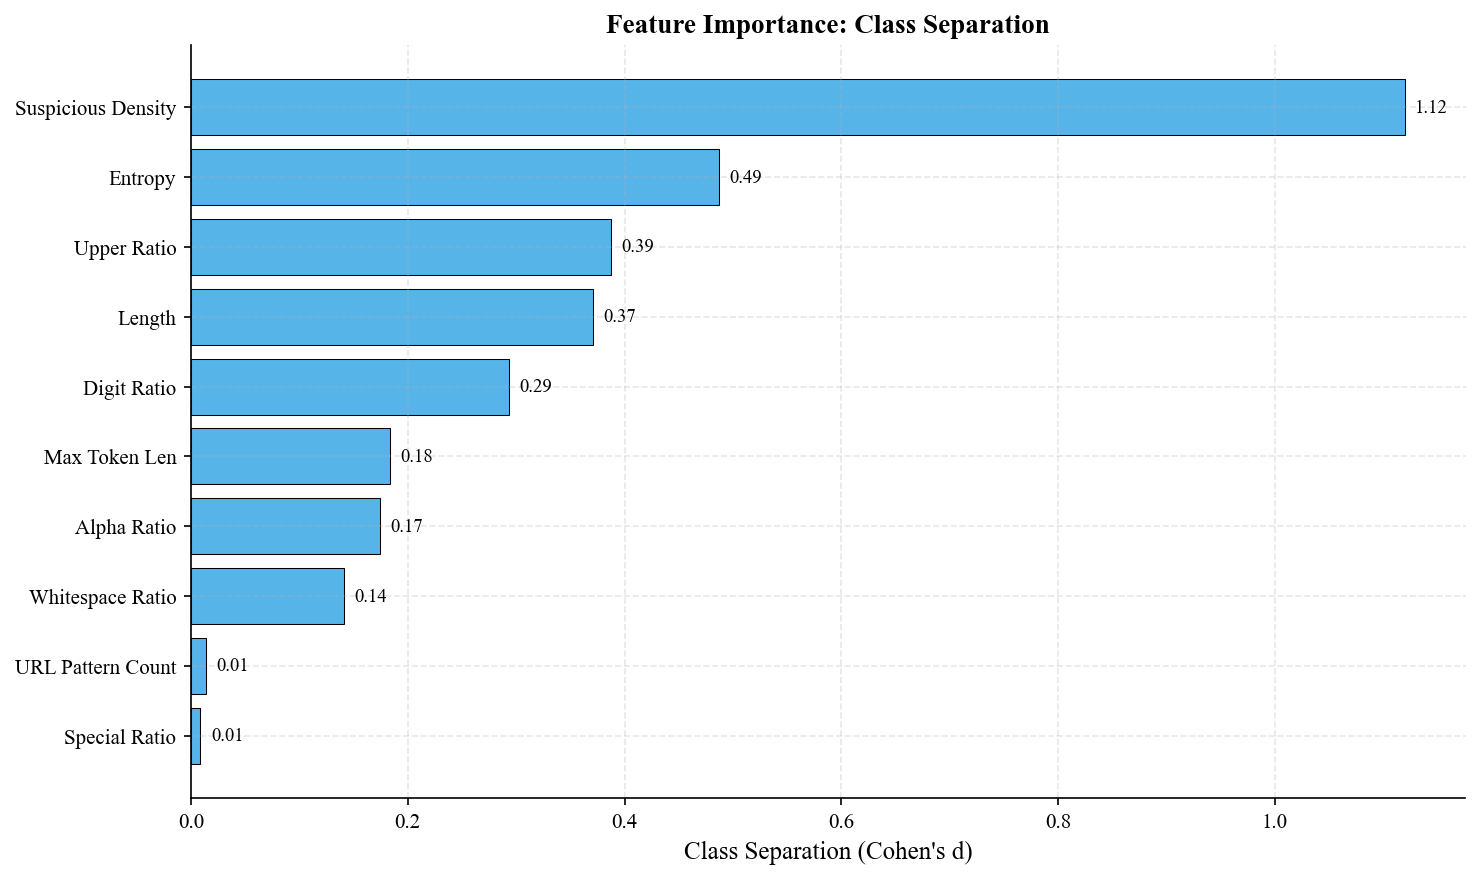

Feature Importance (Class Separation):
  Suspicious Density: 1.120
  Entropy: 0.487
  Upper Ratio: 0.388
  Length: 0.371
  Digit Ratio: 0.293
  Max Token Len: 0.184
  Alpha Ratio: 0.174
  Whitespace Ratio: 0.141
  URL Pattern Count: 0.014
  Special Ratio: 0.009


In [8]:
# Compute class separation (difference of means / pooled std)
separations = []
for feature in FEATURE_NAMES:
    benign_vals = features_df[features_df['label'] == 'benign'][feature]
    attack_vals = features_df[features_df['label'] == 'attack'][feature]
    
    mean_diff = abs(benign_vals.mean() - attack_vals.mean())
    pooled_std = np.sqrt((benign_vals.var() + attack_vals.var()) / 2)
    
    separation = mean_diff / (pooled_std + 1e-9)
    separations.append({'feature': feature, 'separation': separation})

sep_df = pd.DataFrame(separations).sort_values('separation', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(range(len(sep_df)), sep_df['separation'],
               color=COLORS['primary'], edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(sep_df)))
ax.set_yticklabels(sep_df['feature'])
ax.set_xlabel('Class Separation (Cohen\'s d)')
ax.set_title('Feature Importance: Class Separation')

for bar, val in zip(bars, sep_df['separation']):
    ax.annotate(f'{val:.2f}', xy=(val, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords='offset points', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_importance.png'), dpi=600)
plt.show()

print("Feature Importance (Class Separation):")
for _, row in sep_df.iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['separation']:.3f}")

### 4.5 Feature Space Visualization (PCA)

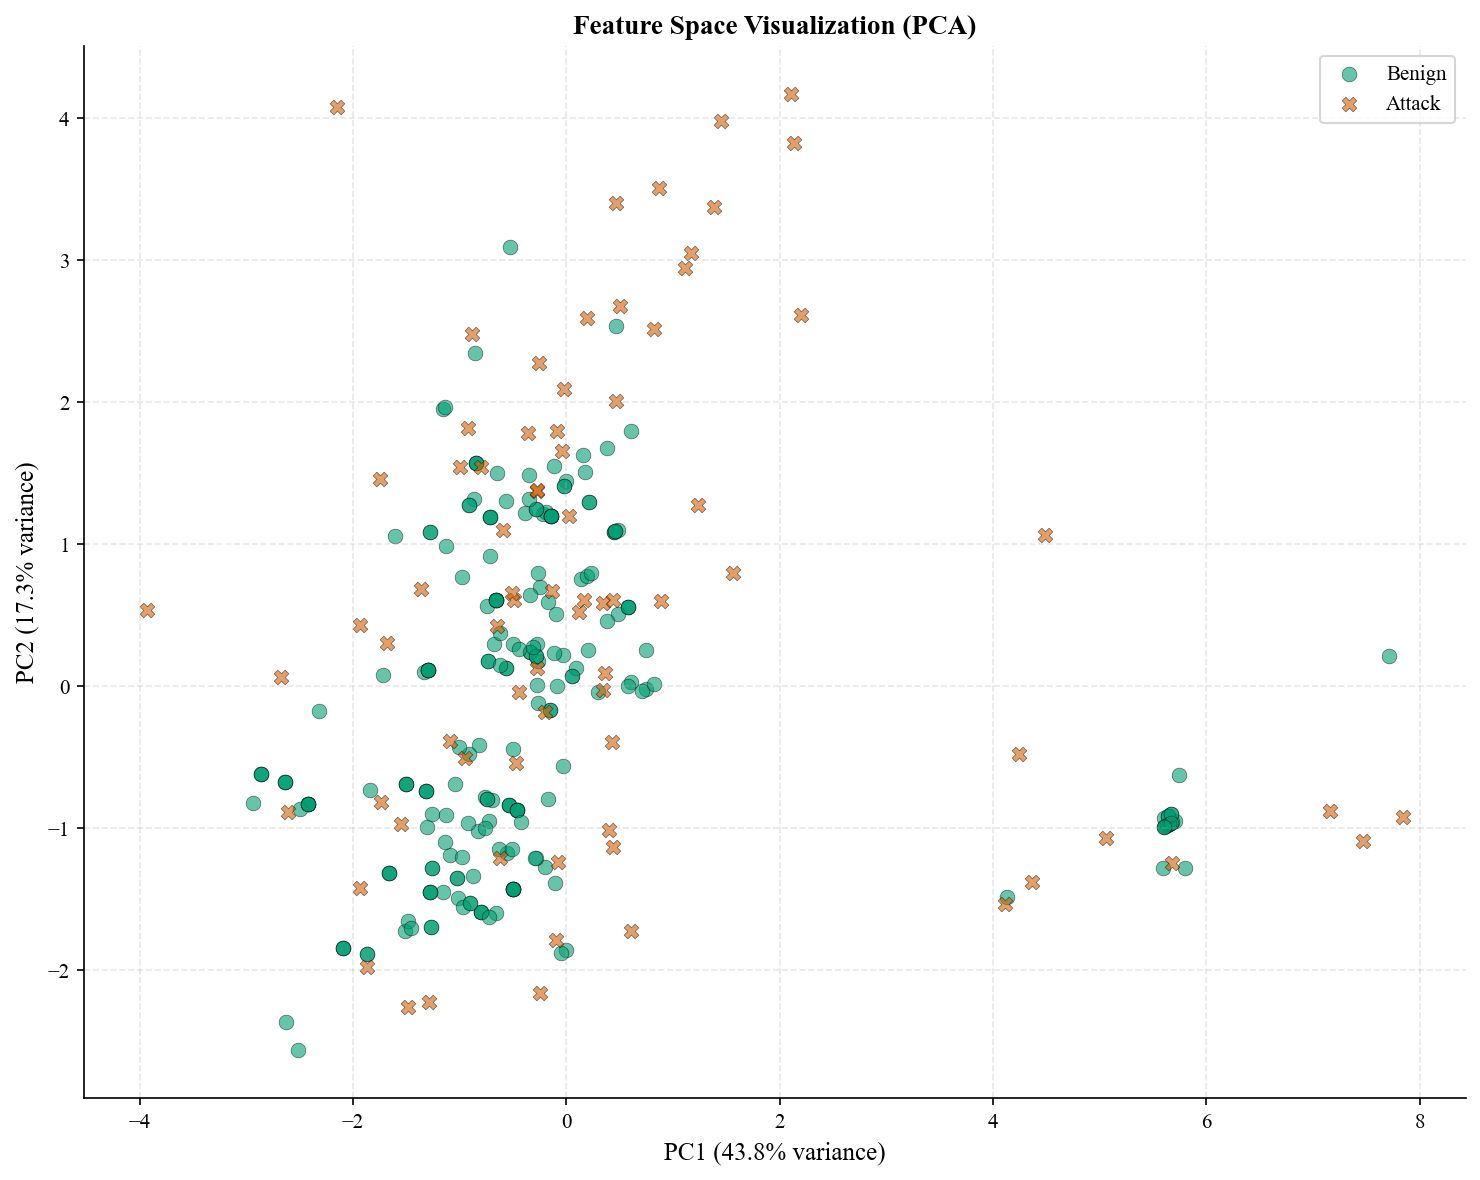


PCA Explained Variance:
  PC1: 43.8%
  PC2: 17.3%
  Total: 61.1%


In [9]:
# PCA visualization
from sklearn.preprocessing import StandardScaler

X = features_df[FEATURE_NAMES].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

for label, color, marker in [('benign', COLORS['benign'], 'o'), ('attack', COLORS['attack'], 'X')]:
    mask = features_df['label'] == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=label.capitalize(),
               alpha=0.6, s=50, marker=marker, edgecolors='black', linewidth=0.3)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Feature Space Visualization (PCA)')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'pca_visualization.png'), dpi=600)
plt.show()

print(f"\nPCA Explained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"  Total: {sum(pca.explained_variance_ratio_):.1%}")

## 5. Model Evaluation

### 5.1 Predictions on Test Set

In [10]:
def evaluate_statistical_detector(samples: List[Dict]) -> pd.DataFrame:
    """Evaluate statistical detector on samples."""
    results = []
    
    for sample in samples:
        result = stat_detector.predict(sample['payload'], sample['tool_name'])
        
        if result is None:
            pred_label = 'abstain'
            confidence = 0.0
            distances = {}
        else:
            pred_label = result.classification
            confidence = result.confidence
            distances = result.metadata.get('distances', {})
        
        results.append({
            'tool_name': sample['tool_name'],
            'payload': sample['payload'][:80],
            'true_label': sample['label'],
            'pred_label': pred_label,
            'confidence': confidence,
            'dist_benign': distances.get('benign', np.nan),
            'dist_attack': distances.get('attack', np.nan)
        })
    
    return pd.DataFrame(results)

print("Evaluating Statistical Detector on test set...")
eval_df = evaluate_statistical_detector(test_samples)
print(f"Evaluation complete: {len(eval_df)} samples")
print(f"\nPrediction distribution:")
print(eval_df['pred_label'].value_counts())

Evaluating Statistical Detector on test set...
Evaluation complete: 304 samples

Prediction distribution:
pred_label
attack    252
benign     52
Name: count, dtype: int64


### 5.2 Confusion Matrix

Coverage: 100.0% (304/304 samples)


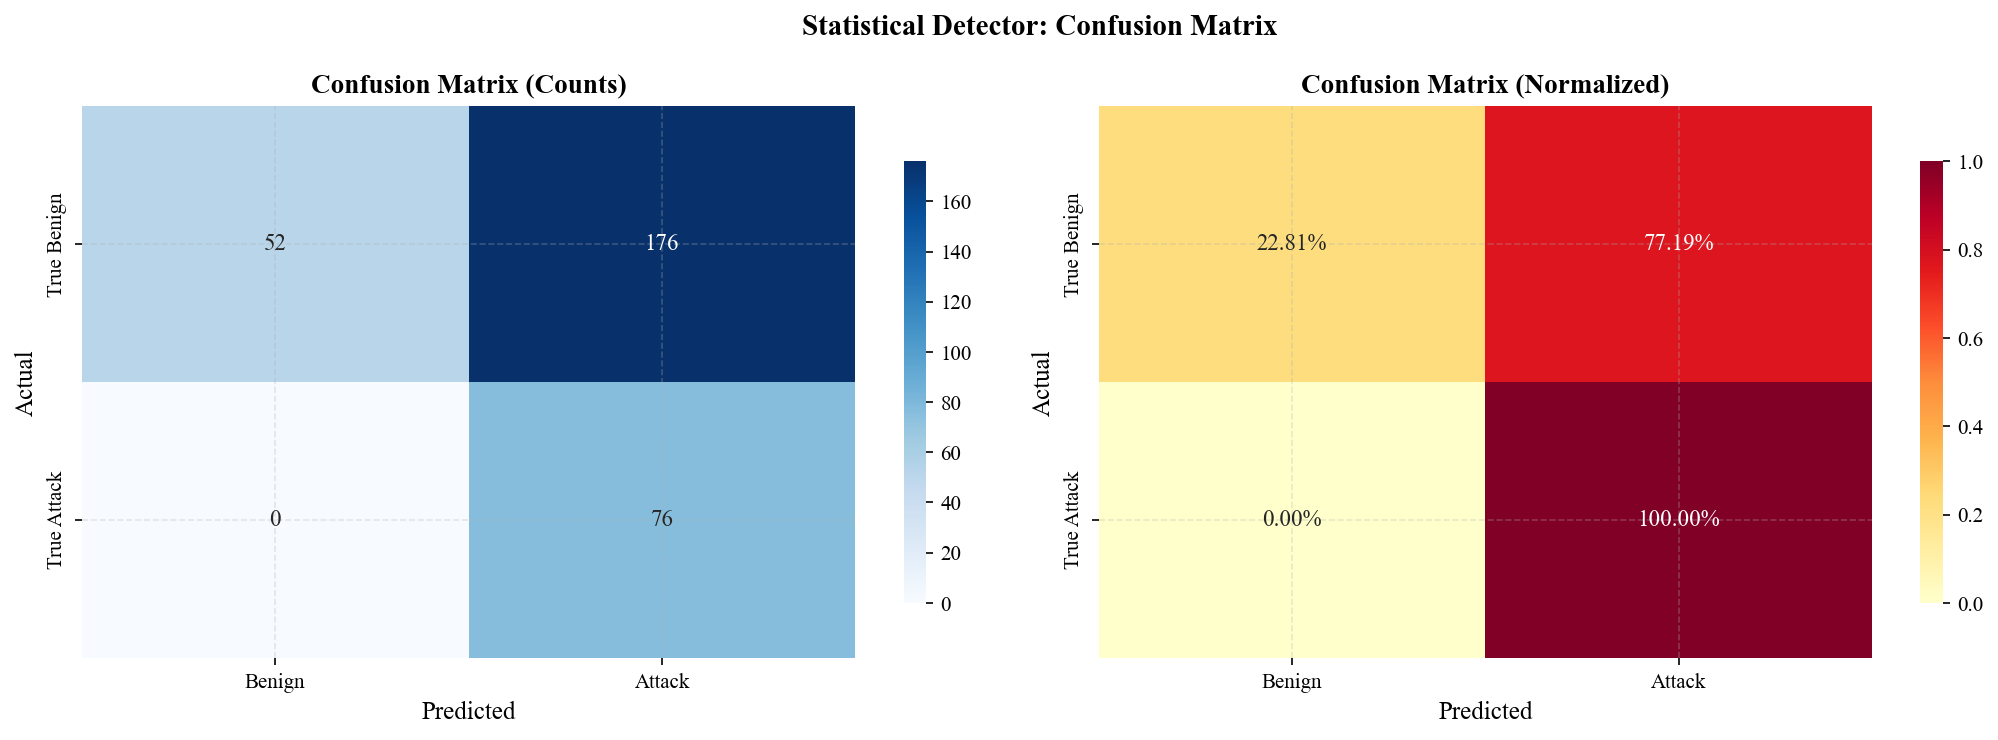

In [11]:
# Filter out abstentions for metrics
valid_df = eval_df[eval_df['pred_label'] != 'abstain'].copy()
coverage = len(valid_df) / len(eval_df)

print(f"Coverage: {coverage:.1%} ({len(valid_df)}/{len(eval_df)} samples)")

if len(valid_df) > 0:
    labels = ['benign', 'attack']
    cm = confusion_matrix(valid_df['true_label'], valid_df['pred_label'], labels=labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Absolute counts
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['True Benign', 'True Attack'],
                ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix (Counts)')
    
    # Normalized
    ax2 = axes[1]
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=['Benign', 'Attack'],
                yticklabels=['True Benign', 'True Attack'],
                ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title('Confusion Matrix (Normalized)')
    
    plt.suptitle('Statistical Detector: Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'), dpi=600)
    plt.show()

### 5.3 Classification Metrics

In [12]:
if len(valid_df) > 0:
    y_true = (valid_df['true_label'] == 'attack').astype(int)
    y_pred = (valid_df['pred_label'] == 'attack').astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision_val = precision_score(y_true, y_pred, zero_division=0)
    recall_val = recall_score(y_true, y_pred, zero_division=0)
    f1_val = f1_score(y_true, y_pred, zero_division=0)
    
    print("Classification Metrics (Binary: Attack Detection)")
    print("="*60)
    print(f"Coverage: {coverage:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Attack']))

Classification Metrics (Binary: Attack Detection)
Coverage: 1.0000
Accuracy: 0.4211
Precision: 0.3016
Recall: 1.0000
F1-Score: 0.4634

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.23      0.37       228
      Attack       0.30      1.00      0.46        76

    accuracy                           0.42       304
   macro avg       0.65      0.61      0.42       304
weighted avg       0.83      0.42      0.39       304



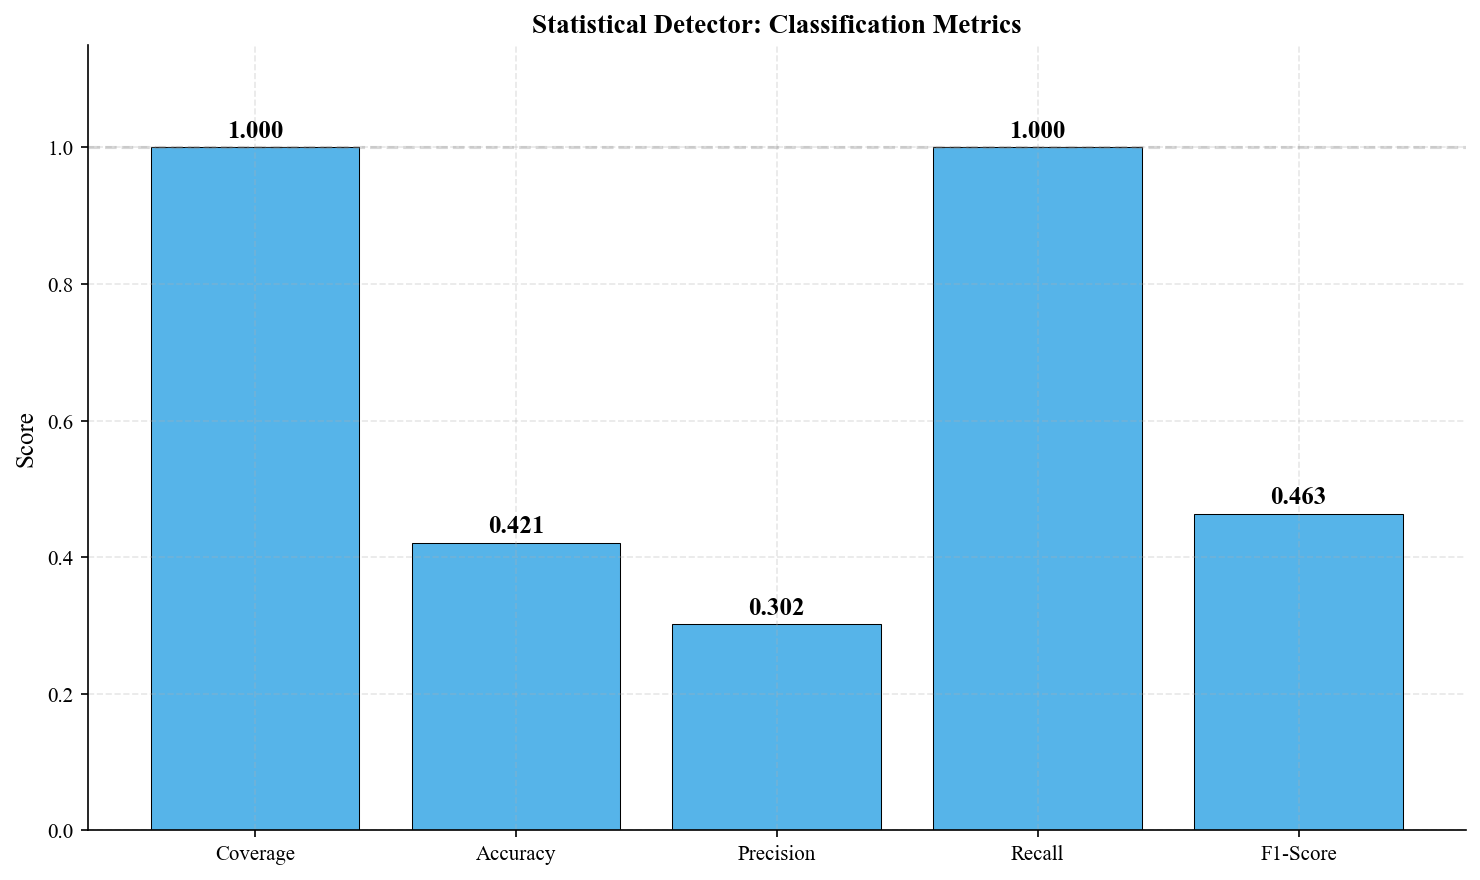

In [13]:
# Visualize metrics
if len(valid_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metrics = ['Coverage', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [coverage, accuracy, precision_val, recall_val, f1_val]
    
    bars = ax.bar(metrics, values, color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center',
                    fontsize=12, fontweight='bold')
    
    ax.set_ylim(0, 1.15)
    ax.set_ylabel('Score')
    ax.set_title('Statistical Detector: Classification Metrics')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'classification_metrics.png'), dpi=600)
    plt.show()

### 5.4 ROC Curve and AUC

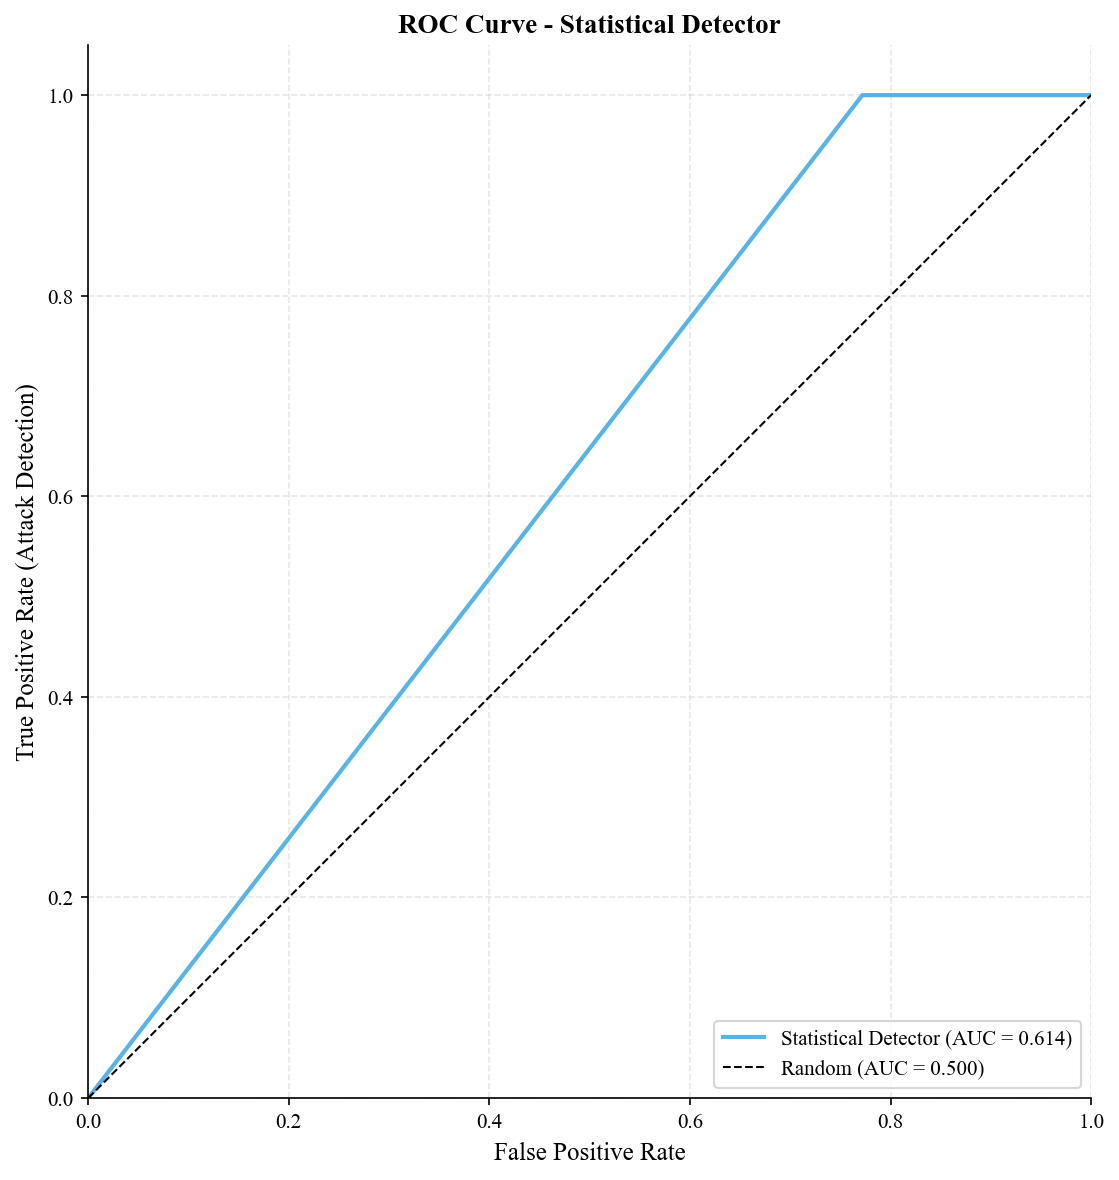

ROC-AUC Score: 0.6140


In [14]:
if len(valid_df) > 0:
    # Use confidence as score (higher confidence for attack prediction)
    y_score = valid_df.apply(
        lambda r: r['confidence'] if r['pred_label'] == 'attack' else (1 - r['confidence']),
        axis=1
    )
    
    fpr_roc, tpr_roc, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr_roc, tpr_roc)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(fpr_roc, tpr_roc, color=COLORS['primary'], lw=2,
            label=f'Statistical Detector (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Attack Detection)')
    ax.set_title('ROC Curve - Statistical Detector')
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'), dpi=600)
    plt.show()
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")

### 5.5 Precision-Recall Curve

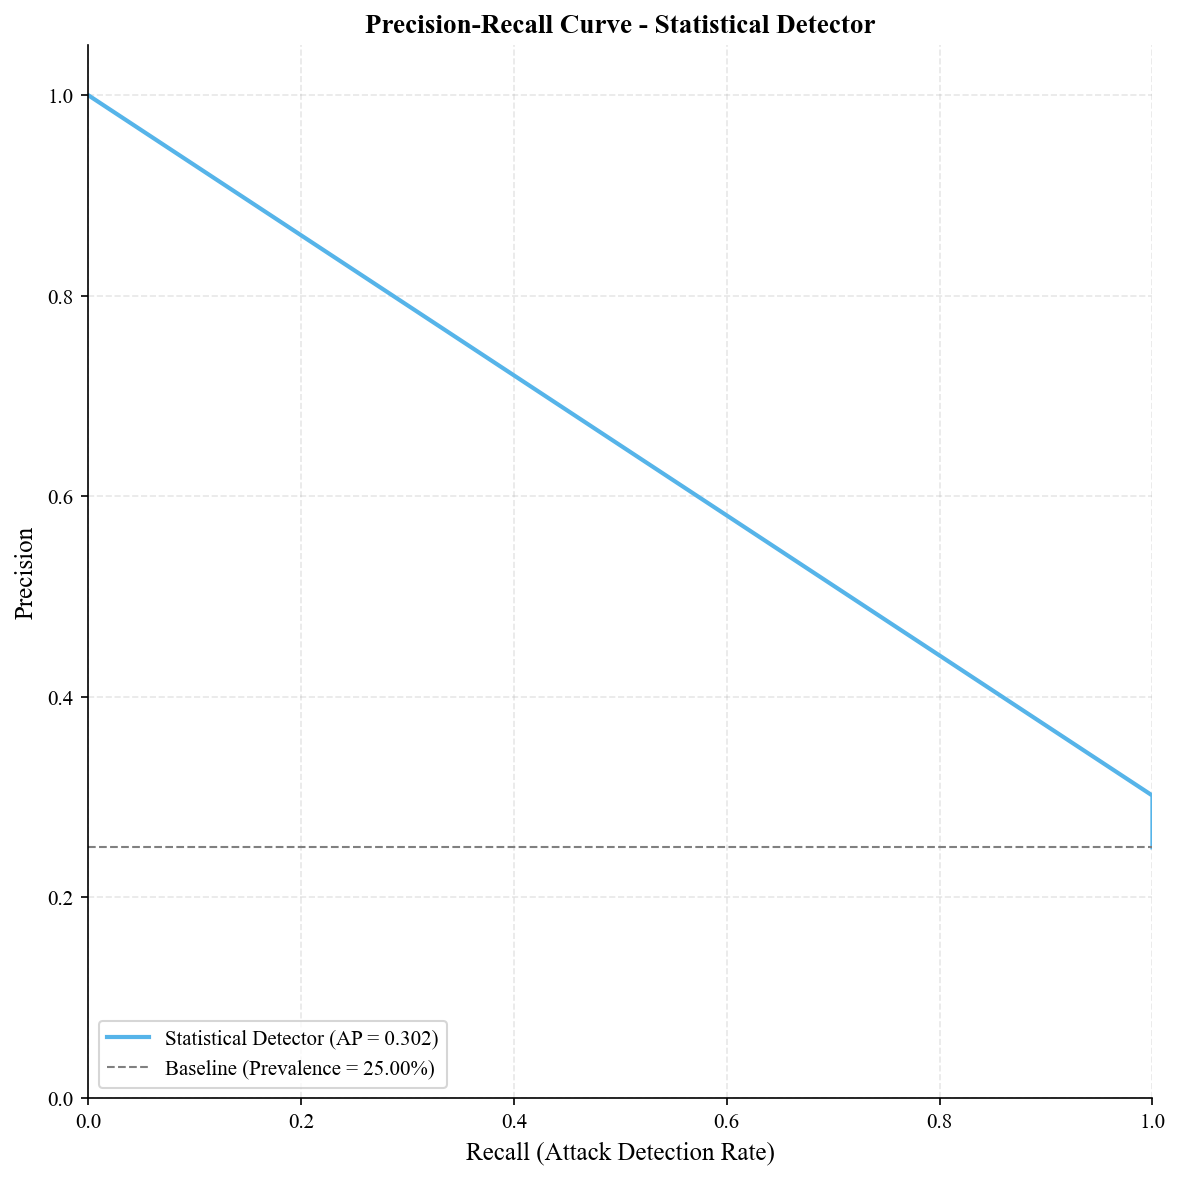

Average Precision (AP): 0.3016


In [15]:
if len(valid_df) > 0:
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.plot(recall_curve, precision_curve, color=COLORS['primary'], lw=2,
            label=f'Statistical Detector (AP = {ap_score:.3f})')
    
    baseline = y_true.mean()
    ax.axhline(y=baseline, color='gray', linestyle='--', lw=1,
               label=f'Baseline (Prevalence = {baseline:.2%})')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('Recall (Attack Detection Rate)')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve - Statistical Detector')
    ax.legend(loc='lower left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'precision_recall_curve.png'), dpi=600)
    plt.show()
    
    print(f"Average Precision (AP): {ap_score:.4f}")

## 6. Mahalanobis Distance Analysis

### 6.1 Distance Distributions

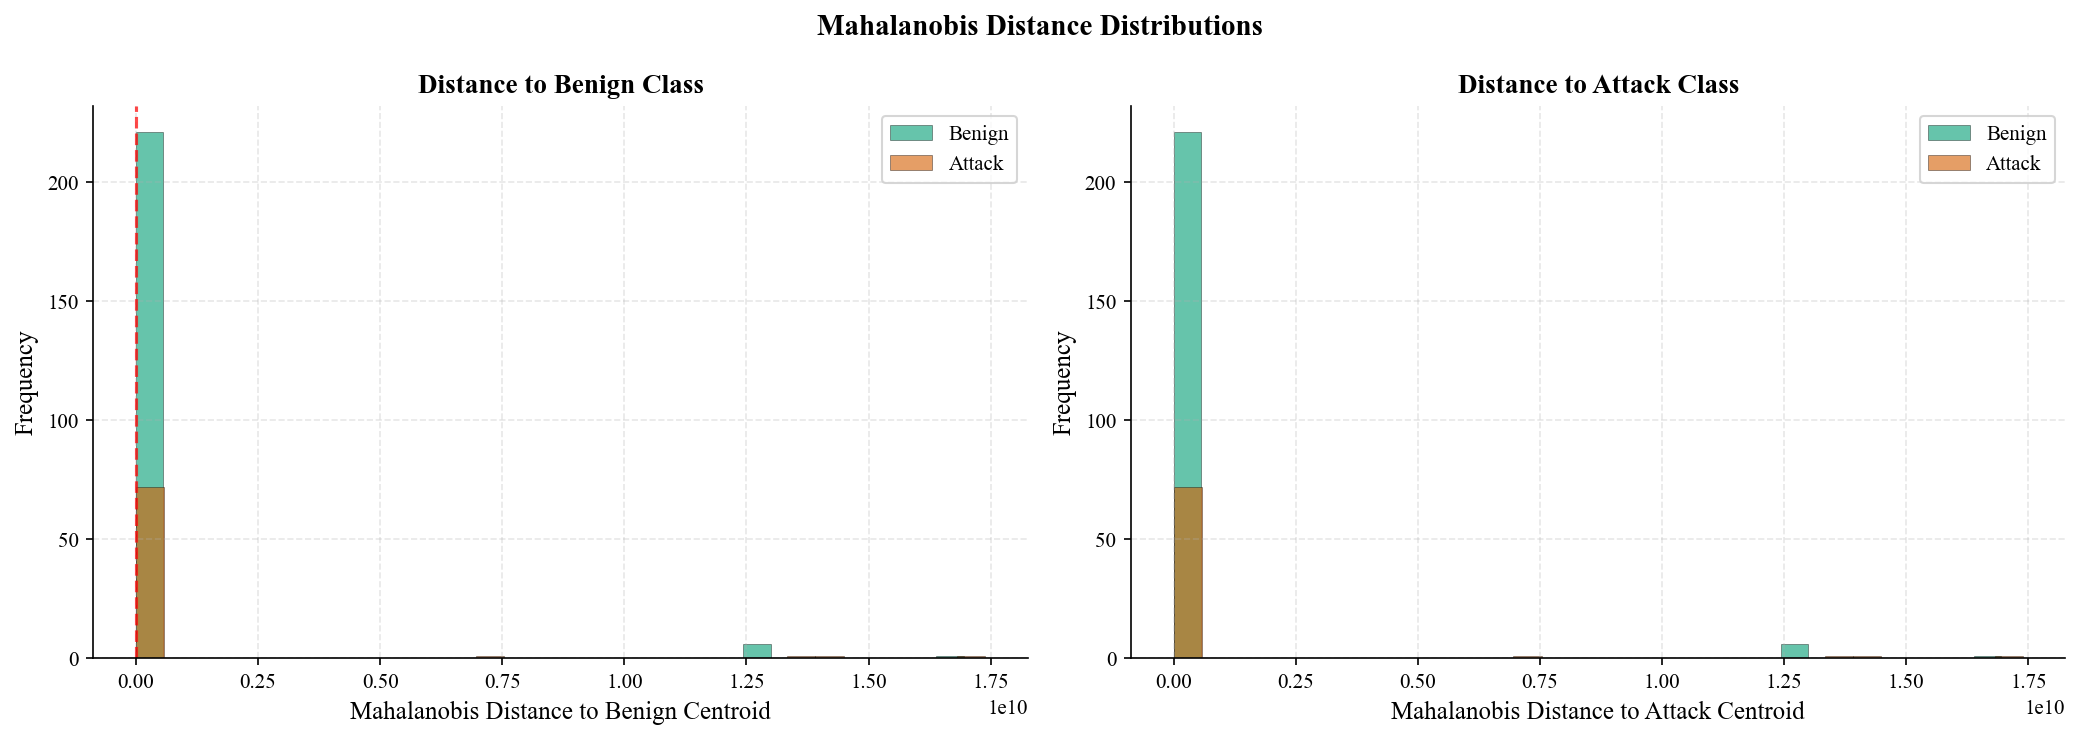

In [16]:
# Analyze Mahalanobis distances
dist_df = eval_df.dropna(subset=['dist_benign'])

if len(dist_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distance to benign prototype
    ax1 = axes[0]
    for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
        data = dist_df[dist_df['true_label'] == label]['dist_benign']
        ax1.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                color=color, edgecolor='black', linewidth=0.3)
    ax1.set_xlabel('Mahalanobis Distance to Benign Centroid')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance to Benign Class')
    ax1.legend()
    ax1.axvline(x=30.0, color='red', linestyle='--', alpha=0.7, label='Chi² threshold')
    
    # Distance to attack prototype
    ax2 = axes[1]
    dist_attack_df = dist_df.dropna(subset=['dist_attack'])
    if len(dist_attack_df) > 0:
        for label, color in [('benign', COLORS['benign']), ('attack', COLORS['attack'])]:
            data = dist_attack_df[dist_attack_df['true_label'] == label]['dist_attack']
            ax2.hist(data, bins=30, alpha=0.6, label=label.capitalize(),
                    color=color, edgecolor='black', linewidth=0.3)
        ax2.set_xlabel('Mahalanobis Distance to Attack Centroid')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Distance to Attack Class')
        ax2.legend()
    
    plt.suptitle('Mahalanobis Distance Distributions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'mahalanobis_distances.png'), dpi=600)
    plt.show()

### 6.2 Decision Boundary Visualization

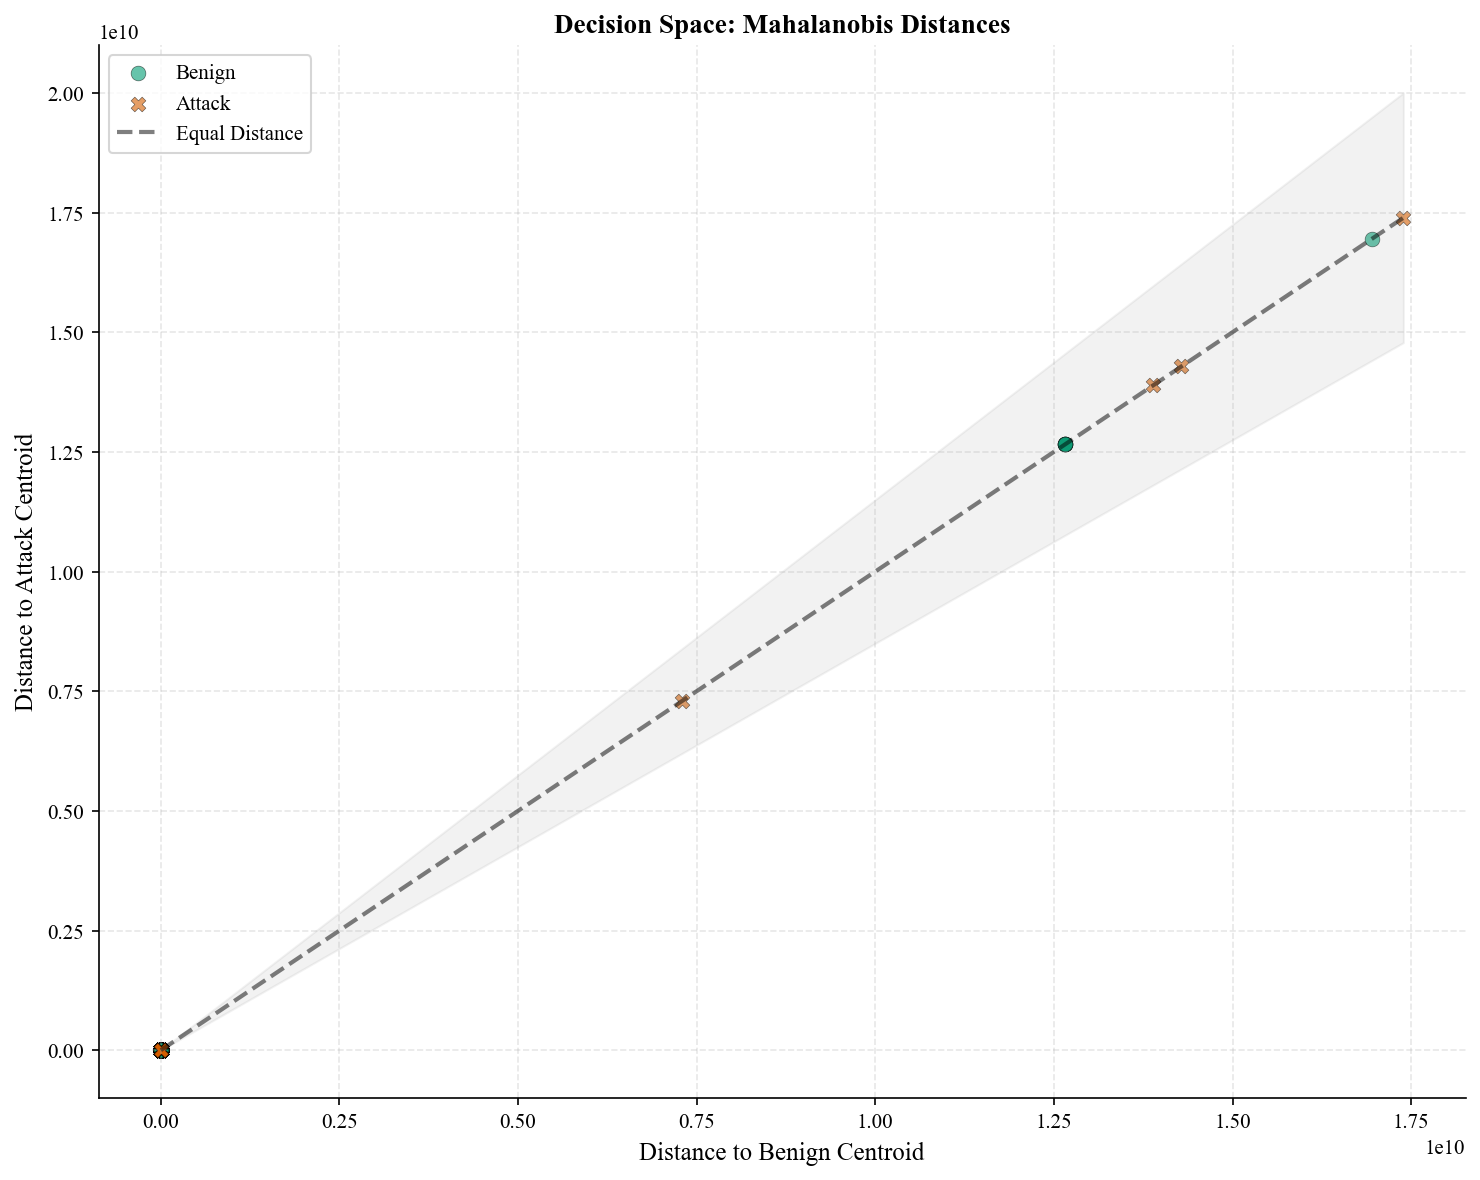

In [17]:
# Scatter plot of distances
both_dist_df = eval_df.dropna(subset=['dist_benign', 'dist_attack'])

if len(both_dist_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for label, color, marker in [('benign', COLORS['benign'], 'o'), ('attack', COLORS['attack'], 'X')]:
        mask = both_dist_df['true_label'] == label
        ax.scatter(both_dist_df[mask]['dist_benign'],
                  both_dist_df[mask]['dist_attack'],
                  c=color, label=label.capitalize(), alpha=0.6, s=50,
                  marker=marker, edgecolors='black', linewidth=0.3)
    
    # Decision boundary (equal distance line)
    max_dist = max(both_dist_df['dist_benign'].max(), both_dist_df['dist_attack'].max())
    ax.plot([0, max_dist], [0, max_dist], 'k--', lw=2, alpha=0.5, label='Equal Distance')
    
    ax.set_xlabel('Distance to Benign Centroid')
    ax.set_ylabel('Distance to Attack Centroid')
    ax.set_title('Decision Space: Mahalanobis Distances')
    ax.legend()
    
    # Add margin region
    ax.fill_between([0, max_dist], [0, max_dist * 0.85], [0, max_dist * 1.15],
                    alpha=0.1, color='gray', label='Ambiguous Region')
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'decision_boundary.png'), dpi=600)
    plt.show()

## 7. Per-Tool Analysis

In [18]:
# Per-tool performance
tool_metrics = []

for tool_name in eval_df['tool_name'].unique():
    tool_df = eval_df[eval_df['tool_name'] == tool_name]
    tool_valid = tool_df[tool_df['pred_label'] != 'abstain']
    
    if len(tool_valid) == 0:
        continue
    
    y_true_tool = (tool_valid['true_label'] == 'attack').astype(int)
    y_pred_tool = (tool_valid['pred_label'] == 'attack').astype(int)
    
    tool_metrics.append({
        'tool': tool_name,
        'samples': len(tool_df),
        'coverage': len(tool_valid) / len(tool_df),
        'accuracy': accuracy_score(y_true_tool, y_pred_tool),
        'f1_score': f1_score(y_true_tool, y_pred_tool, zero_division=0)
    })

tool_metrics_df = pd.DataFrame(tool_metrics).sort_values('f1_score', ascending=False)

print("Per-Tool Performance:")
print(tool_metrics_df.to_string(index=False))

Per-Tool Performance:
            tool  samples  coverage  accuracy  f1_score
    send_webhook       32       1.0  0.593750  0.551724
 render_template       32       1.0  0.500000  0.500000
       parse_xml       32       1.0  0.468750  0.484848
deserialize_data       32       1.0  0.437500  0.470588
   redis_command       40       1.0  0.375000  0.444444
    s3_operation       32       1.0  0.375000  0.444444
      ldap_query       36       1.0  0.361111  0.439024
      verify_jwt       28       1.0  0.357143  0.437500
   graphql_query       40       1.0  0.350000  0.434783


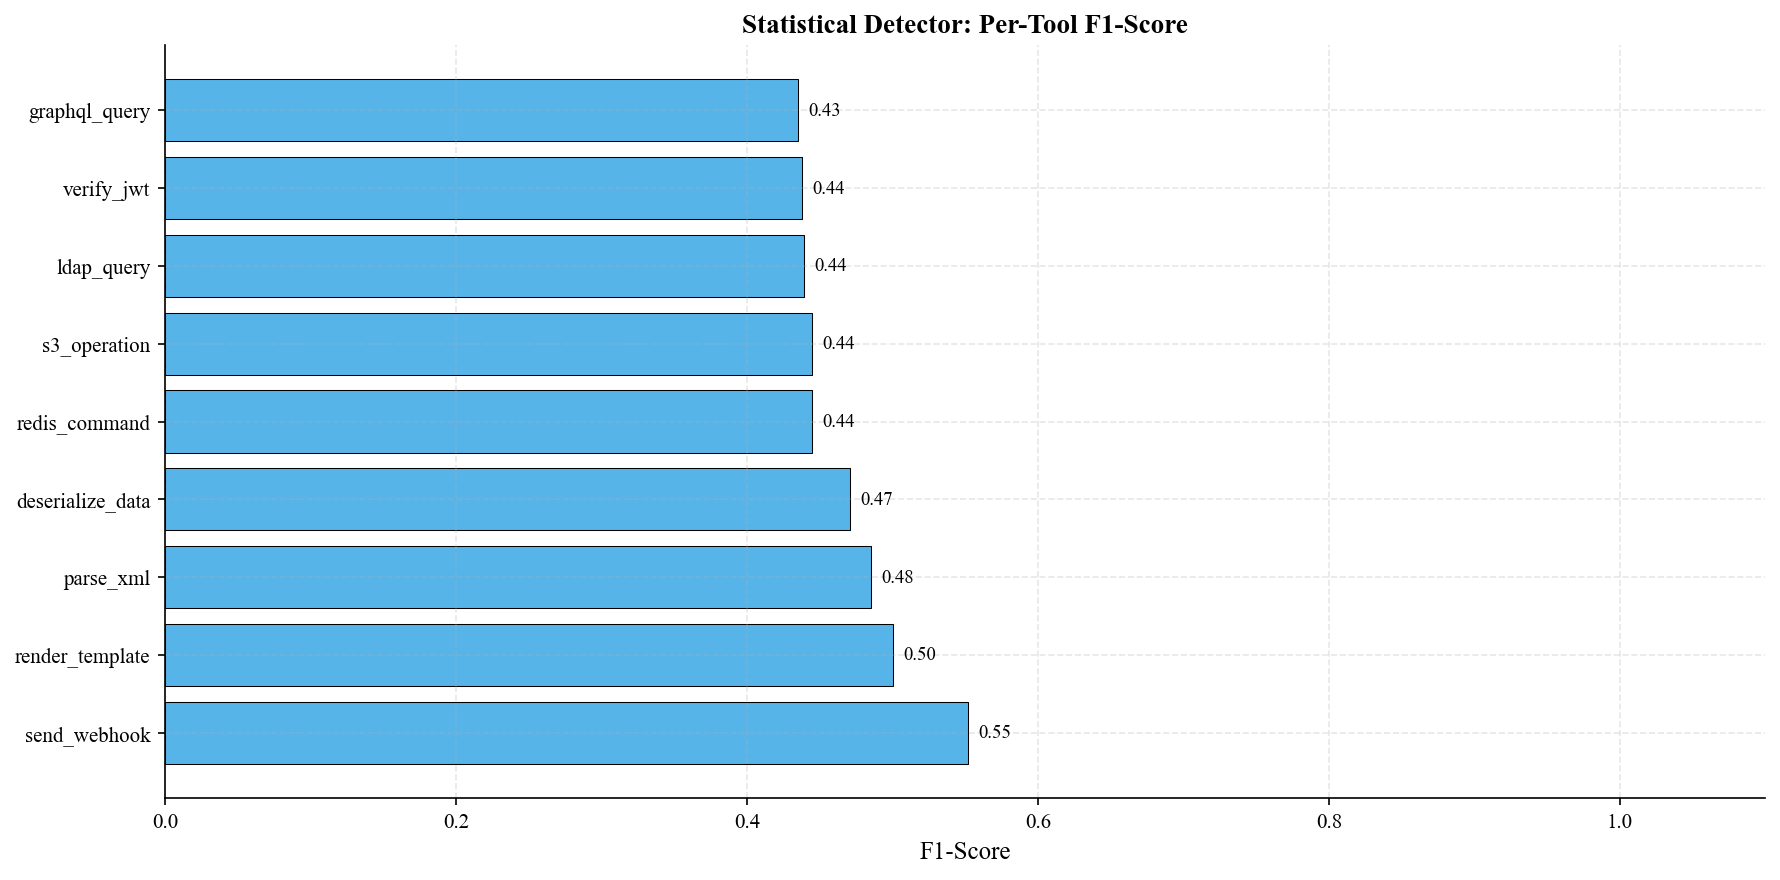

In [19]:
# Visualize per-tool F1 scores
if len(tool_metrics_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.barh(range(len(tool_metrics_df)), tool_metrics_df['f1_score'],
                   color=COLORS['primary'], edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(tool_metrics_df)))
    ax.set_yticklabels(tool_metrics_df['tool'])
    ax.set_xlabel('F1-Score')
    ax.set_title('Statistical Detector: Per-Tool F1-Score')
    ax.set_xlim(0, 1.1)
    
    for bar, val in zip(bars, tool_metrics_df['f1_score']):
        ax.annotate(f'{val:.2f}', xy=(val, bar.get_y() + bar.get_height()/2),
                    xytext=(5, 0), textcoords='offset points', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'per_tool_f1.png'), dpi=600)
    plt.show()

## 8. Summary and Export

In [20]:
# Compile summary
summary = {
    'detector': 'statistical',
    'classification_type': 'binary',
    'method': 'mahalanobis_distance',
    'features': FEATURE_NAMES,
    'n_features': len(FEATURE_NAMES),
    'tools_trained': list(stat_detector.class_stats.keys()),
    'test_samples': len(eval_df),
    'metrics': {
        'coverage': float(coverage),
        'accuracy': float(accuracy) if len(valid_df) > 0 else None,
        'precision': float(precision_val) if len(valid_df) > 0 else None,
        'recall': float(recall_val) if len(valid_df) > 0 else None,
        'f1_score': float(f1_val) if len(valid_df) > 0 else None,
        'roc_auc': float(roc_auc) if len(valid_df) > 0 else None,
        'average_precision': float(ap_score) if len(valid_df) > 0 else None
    },
    'feature_importance': sep_df.to_dict('records'),
    'per_tool_metrics': tool_metrics
}

# Export
eval_df.to_csv(os.path.join(RESULTS_DIR, 'statistical_predictions.csv'), index=False)
features_df.to_csv(os.path.join(RESULTS_DIR, 'statistical_features.csv'), index=False)
tool_metrics_df.to_csv(os.path.join(RESULTS_DIR, 'statistical_per_tool.csv'), index=False)

with open(os.path.join(RESULTS_DIR, 'statistical_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("Results exported successfully.")

Results exported successfully.


In [21]:
# Final summary
print("\n" + "="*70)
print("STATISTICAL DETECTOR EVALUATION SUMMARY")
print("="*70)
print(f"\nMethod: Mahalanobis Distance-based Anomaly Detection")
print(f"Features: {len(FEATURE_NAMES)} statistical features")
print(f"Tools trained: {len(stat_detector.class_stats)}")
print(f"\nBinary Classification Performance:")
if len(valid_df) > 0:
    print(f"  Coverage:  {coverage:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision_val:.4f}")
    print(f"  Recall:    {recall_val:.4f}")
    print(f"  F1-Score:  {f1_val:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  AP:        {ap_score:.4f}")
print("="*70)


STATISTICAL DETECTOR EVALUATION SUMMARY

Method: Mahalanobis Distance-based Anomaly Detection
Features: 10 statistical features
Tools trained: 32

Binary Classification Performance:
  Coverage:  1.0000
  Accuracy:  0.4211
  Precision: 0.3016
  Recall:    1.0000
  F1-Score:  0.4634
  ROC-AUC:   0.6140
  AP:        0.3016


## Conclusions

### Key Findings

1. **Feature Engineering**: The 10 statistical features capture meaningful differences between benign and attack payloads, with Suspicious Density and Entropy showing highest discriminative power.

2. **Mahalanobis Distance**: The distance-based approach effectively identifies anomalous requests by modeling class distributions in feature space.

3. **Fail-Safe Behavior**: Ambiguous cases (similar distance to both classes) are classified as attacks, prioritizing security over availability.

4. **Per-Tool Adaptation**: The detector learns separate class statistics for each tool, enabling tool-specific anomaly detection.

### Role in Ensemble

The Statistical Detector:
- Provides anomaly detection capability for requests with unusual statistical profiles
- Complements rule-based detection by catching novel attack patterns
- Offers fast inference with low computational overhead
- Contributes to ensemble voting with calibrated confidence scores

### Limitations

- May miss semantically sophisticated attacks with normal statistical profiles
- Requires sufficient training data per tool for accurate statistics
- Feature engineering is manual and may not capture all attack characteristics

---

*Evaluation completed. Results saved for thesis documentation.*